In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#載入所需套件

In [2]:
#載入train.csv，並且分成y(output)和x(input)
df=pd.read_csv('train.csv')
dy=df['Exited']
dx=df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

#使用get_dummies將類別型資料轉成onehot型式
dX=pd.get_dummies(dx,columns=['Geography','Gender'])
feature_names=list(dX.columns)

#將資料標準化
dX_std=StandardScaler().fit_transform(dX)
dX_std[1]
dX.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,720,38,5,114051.97,2,0,1,107577.29,0,0,1,0,1
1,682,54,4,62397.41,1,1,0,113088.60,1,0,0,1,0
2,672,31,5,119903.67,1,1,1,132925.17,1,0,0,1,0
3,592,40,4,104257.86,1,1,0,110857.33,0,0,1,1,0
4,753,42,5,120387.73,1,0,1,126378.57,0,0,1,0,1


In [3]:
#把資料分割成train data, test data
dx_train,dx_test,dy_train,dy_test=train_test_split(dX_std,dy,test_size=0.2,random_state=0)
print(dx_test.shape)
print(dy_test.shape)
print(dx_train.shape)
print(dy_train.shape)

(1600, 13)
(1600,)
(6400, 13)
(6400,)


In [4]:
#分割資料，將資料分成3份，以便使用Cross-Validation的方法進行驗證
cv=StratifiedKFold(n_splits=3)

test_acc_scores=[]
test_precision_scores=[]
test_f1_scores=[]
test_final_scores=[]
para=[]
cv_acc_scores=[]
cv_precision_scores=[]
cv_f1_scores=[]
cv_final_scores=[]

In [5]:
#設定parameter矩陣，用以後續檢驗哪種超參數代入模型後的表現最好
n_para=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]

#for迴圈用來檢驗超參數，並使用兩種檢驗方法，一種是單純將資料分成train和test，另一種則是使用交叉驗證法
#分別計算兩種檢驗方法的accuracy, precision, f1_score，並且使用網站給定的三種權重(0.3*accuracy+0.4*precision+0.4*f1_score)算出
#兩種檢驗方法下的各個不同超參數的final_score
for n in n_para:
    knn=KNeighborsClassifier(n_neighbors=n)
    knn.fit(dx_train,dy_train)
    predictions=knn.predict(dx_test)
    
    test_acc_scores.append(knn.score(dx_test,dy_test))
    
    precision=precision_score(dy_test, predictions)
    recall=recall_score(dy_test, predictions)
    f1_score=(2*precision*recall)/(precision+recall)
    
    test_precision_scores.append(precision)
    test_f1_scores.append(f1_score)
    test_final_scores.append(0.3*knn.score(dx_test,dy_test)+0.4*precision+0.4*f1_score)

    
    
    acc_sum=0
    precision_sum=0
    f1_sum=0
    final_score=0
    for train_index,test_index in cv.split(dx_train,dy_train):
        x_train=dx_train[train_index]
        x_test=dx_train[test_index]
        y_train=dy_train.iloc[train_index]
        y_test=dy_train.iloc[test_index]
        
        knn.fit(x_train,y_train)
        predictions2=knn.predict(x_test)
        acc_sum=acc_sum+knn.score(x_test,y_test)
        
        precision2=precision_score(y_test, predictions2)
        recall2=recall_score(y_test, predictions2)
        f1_score2=(2*precision2*recall2)/(precision2+recall2)
        
        precision_sum=precision_sum+precision2
        f1_sum=f1_sum+f1_score2
        final_score=final_score+0.3*knn.score(x_test,y_test)+0.4*precision2+0.4*f1_score2
    
    cv_acc_scores.append(acc_sum/3)
    cv_precision_scores.append(precision_sum/3)
    cv_f1_scores.append(f1_sum/3)
    cv_final_scores.append(final_score/3)
    

In [6]:
#將結果放入Dataframe(此處為test_train分割的結果)
test_score=pd.DataFrame({
    'acc':test_acc_scores,
    'precision':test_precision_scores,
    'f1':test_f1_scores,
    'final_score':test_final_scores
},index=n_para)
test_score

,acc,precision,f1,final_score
1,0.796875,0.508711,0.473258,0.631850
2,0.820625,0.686957,0.355056,0.662993
3,0.817500,0.593137,0.453184,0.663778
4,0.825000,0.708333,0.377778,0.681944
5,0.828750,0.657303,0.460630,0.695798
6,0.833125,0.760331,0.407982,0.717263
7,0.834375,0.704403,0.458078,0.715305
8,0.831250,0.767857,0.389140,0.712174
9,0.835625,0.727891,0.448637,0.721299
10,0.830625,0.770642,0.382688,0.710520


In [7]:
#將結果放入Dataframe(此處為CV的結果)
cv_score=pd.DataFrame({
    'acc':cv_acc_scores,
    'precision':cv_precision_scores,
    'f1':cv_f1_scores,
    'final_score':cv_final_scores
},index=n_para)
cv_score

,acc,precision,f1,final_score
1,0.789688,0.481429,0.456866,0.612225
2,0.818594,0.661302,0.334599,0.643939
3,0.817032,0.579979,0.448980,0.656693
4,0.822188,0.671528,0.361170,0.659736
5,0.822501,0.617201,0.436482,0.668223
6,0.823438,0.687054,0.359391,0.665609
7,0.824376,0.643157,0.416662,0.671240
8,0.823595,0.706457,0.346205,0.668143
9,0.825001,0.666260,0.397017,0.672811
10,0.823595,0.710078,0.343257,0.668412


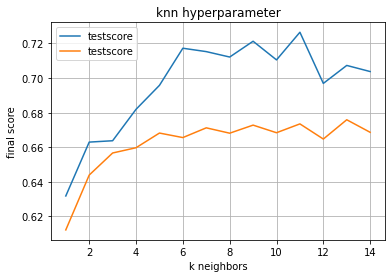

In [8]:
#劃出圖表，並以目測的方式找出各個出現峰值的超參數點
plt.title('knn hyperparameter')
plt.plot(n_para,test_score['final_score'],label='testscore')
plt.plot(n_para,cv_score['final_score'],label='testscore')
plt.xlabel('k neighbors')
plt.ylabel('final score')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#載入測試資料並且標準化
df_test=pd.read_csv('test.csv')
dx2=df_test[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
dx_test2=pd.get_dummies(dx2,columns=['Geography','Gender'])
dx_test_std2=StandardScaler().fit_transform(dx_test2)

In [10]:
#上述結果中目測最好的結果為n=11，故使用此方法
knn=KNeighborsClassifier(n_neighbors=11)
knn.fit(dx_train,dy_train)
prediction_knn=knn.predict(dx_test_std2)
df_knn_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_knn
})
df_knn_out.to_csv('knn_sample2.csv')
#acc: 0.8500
#precision: 0.6923
#fScore: 0.4737
#此處計算在網站上跑出的分數